# **Project: Movie Reviews Sentiment Analysis**

This project focuses on sentiment analysis of movie reviews, aiming to classify them as positive or negative based on textual content. 

The primary objective is to explore and compare the effectiveness of various deep learning models (CNN vs. RNN) for text classification.

**Models**

- Convolutional Neural Networks (CNNs): 

- Recurrent Neural Networks (RNNs):
   - GRU (Gated Recurrent Units): For capturing sequential patterns with fewer parameters.
   - LSTM (Long Short-Term Memory): To capture long-term dependencies in text.
   - Stacked LSTM: to enhance the learning of hierarchical patterns.

**Model Comparison**

Provides insights into the strengths and limitations of different models, especially in handling long and complex text sequences.

- Convolutional Neural Networks (CNNs) are a type of deep learning model primarily designed for image-related tasks (capture spatial features), while Recurrent Neural Networks (RNNs) are designed to process sequential data, making them ideal for time series, natural language processing (NLP), and any data where the order of the data points matters (like text).

- But, in this project, the three-layer CNN model achieved the best performance, with an accuracy of 91%. 

- Possible reasons:

    -  CNN outperforms RNNs (like LSTMs or GRUs) here could be closely tied to the nature of the task: **binary sentiment classification (positive or negative).**
    
    -  Sentiment analysis often relies on **local patterns**:

        Sentiment is usually determined by the presence of specific keywords or short phrases (e.g., "not good," "absolutely amazing").

        CNNs, with their convolutional filters, are exceptionally good at identifying such n-gram patterns.
        
        RNNs process the entire sequence, which can dilute the impact of strong local signals in favor of modeling the overall sequence structure.



In [59]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import  re
import contractions
from bs4 import BeautifulSoup
import tqdm
import unicodedata


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# fix random seeds for reproducibility
seed = 42
np.random.seed(seed)

In [3]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bingh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bingh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bingh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!nvidia-smi

Tue Jan 21 10:17:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             11W /  200W |     753MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
data = pd.read_csv("../data/movie_reviews.csv")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Textual Data Preparation

### Prepare Train and Text Datasets

In [9]:
reviews = data['review'].values
sentiments = data['sentiment'].values

train_review, test_review = np.split(reviews, [35000])
train_sentiment, test_sentiment = np.split(sentiments, [35000])

# or otherways:
# train_review = reviews[:3500]
# test_review = reviews[3500:]

# train_sentiment = sentiments[:3500]
# test_sentiment = sentiments[3500:]

In [10]:
train_review.shape, test_review.shape, train_sentiment.shape, test_sentiment.shape

((35000,), (15000,), (35000,), (15000,))

In [11]:
train_review[:5]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

### Text Preprocessing

The text preprocessing efforts focus on:
- Cleaning: Removing HTML tags, scripts, special characters, and accents.
- Normalization: Ensuring uniform case, spacing, and expanded contractions.
- Preparation: Producing clean, plain text for better performance in NLP tasks.

In [12]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text): # á -> a
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [13]:
train_review_normalized = pre_process_corpus(train_review)
test_review_normalized = pre_process_corpus(test_review)

  1%|▏         | 455/35000 [00:00<00:07, 4521.78it/s]C:\Users\bingh\AppData\Local\Temp\ipykernel_22176\3120417334.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:03<00:00, 4698.25it/s]


In [14]:
train_review_normalized[:5]

['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget prett

### Tokenization (X)

Tokenization

Tokenization is the process of splitting text into smaller units, typically tokens, which can be words, subwords, or characters. For deep learning models, this process often includes mapping these tokens to numerical representations that can be processed by the model.

Note: a Keras Tokenizer behaves like a "trained model" for text preprocessing, Once the tokenizer is fitted, it has a fixed vocabulary (word_index) and mapping between words and integers.

In [15]:
# 1. Initialize the tokenizer with the <UNK> (unknown token)
t = Tokenizer(oov_token='<UNK>')

# 2. Fit the tokenizer only on the training reviews
t.fit_on_texts(train_review_normalized)

# 3. Convert text to sequences
# Transform Both Training and Test Data Using the Same Tokenizer
train_sequences = t.texts_to_sequences(train_review_normalized)
test_sequences = t.texts_to_sequences(test_review_normalized)

In [16]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

# Tokenizer detected 175812 unique words across all documents
# Tokenizer was fitted on 3500 text documents.

Vocabulary size=175812
Number of Documents=35000


Sequence Normalization

In [17]:
max([len(sentence_tokens) for sentence_tokens in train_sequences])

2463

Distribution of train sequence lengths

Plot the sequence length

This analysis helps determine how to handle sequence lengths for training a deep learning model, such as setting an appropriate maxlen for padding or truncation.

C:\Users\bingh\AppData\Local\Temp\ipykernel_22176\3383209453.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


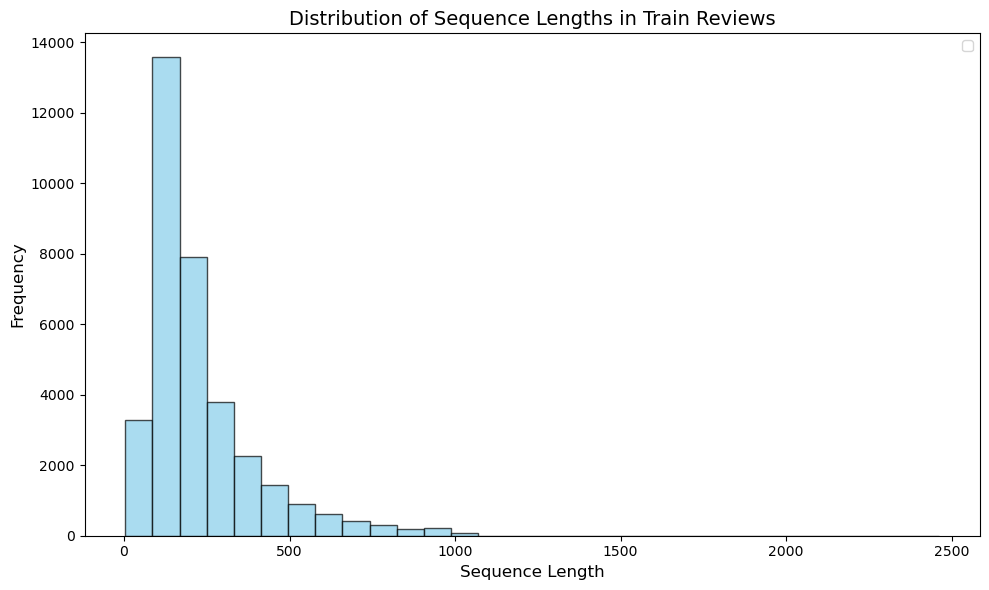

In [18]:
# Calculate lengths of sequences
train_lens = [len(s) for s in train_sequences]

mean_length = np.mean(train_lens)
median_length = np.median(train_lens)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(train_lens, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Sequence Lengths in Train Reviews', fontsize=14)
ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [19]:
MAX_SEQUENCE_LENGTH = 1000

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,  padding='post')
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels (Y)

The dataset contains labels of the form positive/negative. The following step encodes the labels using sklearn's LabelEncoder  

In [20]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(train_sentiment)
y_test = le.transform(test_sentiment)

In [21]:
print(train_sentiment[:5])
print("-" * 50)
print(y_train[:5])

['positive' 'positive' 'positive' 'negative' 'positive']
--------------------------------------------------
[1 1 1 0 1]


In [22]:
print(test_sentiment[:5])
print("-" * 50)
print(y_test[:5])

['negative' 'positive' 'negative' 'positive' 'positive']
--------------------------------------------------
[0 1 0 1 1]


# **CNN Model**

**Prepare the Model**

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

**Embeddings**

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words.

<div style="display: flex; justify-content: space-around;">
  <img src="https://i.imgur.com/wOPsWof.png" alt="Image 1" width="1000">
  <img src="https://i.imgur.com/XRaoZRW.png" alt="Image 2" width="600">
</div>

### Build Model

In [23]:
# the unique number of words in our training data is 175812
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

175812

In [25]:
# Define constants
VOCAB_SIZE = 175813
EMBED_SIZE = 300
MAX_SEQUENCE_LENGTH = 1000 

# Create the model
model_cnn = Sequential()

# Embedding layer is of dim: 175813 x 300
model_cnn.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

# Convolutional and pooling layers
model_cnn.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))  # Regularization; avoid overfitting

model_cnn.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))  # Regularization; avoid overfitting

model_cnn.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Flattening the output
model_cnn.add(Flatten())

# Dense layers for classification
model_cnn.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model_cnn.add(Dropout(0.5))  # Regularization
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         52743900  
                                                                 
 conv1d_3 (Conv1D)           (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 500, 128)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 500, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 64)          0         
 1D)                                                  

### Model Training

In [26]:
EPOCHS = 10
BATCH_SIZE = 128
# Early stop
## using early stopping to prevent overfitting and ensure the best model weights are restored.
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                      patience = 2,
                                      restore_best_weights = True,
                                      verbose = 1)

# Fit the model
model_cnn.fit(X_train, y_train,
          validation_split = 0.1,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks = [es],
          verbose = 1)

Epoch 1/10
247/247 [==============================] - 18s 41ms/step - loss: 0.5516 - accuracy: 0.6544 - val_loss: 0.2733 - val_accuracy: 0.8966
Epoch 2/10
247/247 [==============================] - 10s 39ms/step - loss: 0.1983 - accuracy: 0.9239 - val_loss: 0.2437 - val_accuracy: 0.9037
Epoch 3/10
247/247 [==============================] - 10s 39ms/step - loss: 0.0638 - accuracy: 0.9780 - val_loss: 0.2970 - val_accuracy: 0.8963
Epoch 4/10
247/247 [==============================] - 10s 39ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.4470 - val_accuracy: 0.8711
Epoch 4: early stopping


### Model Evaluation

In [ ]:
scores = model_cnn.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))
print("Test Loss: %.2f%%" % (scores[0]*100))

469/469 [==============================] - 2s 3ms/step - loss: 0.2394 - accuracy: 0.9085
Accuracy: 90.85%


In [28]:
predict_probas = model_cnn.predict(X_test).ravel()  # ravel(): latten an array into a one-dimensional array

469/469 [==============================] - 1s 3ms/step


In [29]:
y_predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]

In [30]:
sentiment_predictions = le.inverse_transform(y_predictions)
sentiment_predictions[:5]

array(['negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [31]:
labels = ['negative', 'positive']
print(classification_report(test_sentiment, sentiment_predictions))
pd.DataFrame(confusion_matrix(test_sentiment, sentiment_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.91      0.91      0.91      7490
    positive       0.91      0.91      0.91      7510

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



,negative,positive
negative,6800,690
positive,682,6828


# **LSTM Model**



**LSTM**

LSTMs try to overcome the shortcomings of RNN models, especially with regard to handling long-term dependencies and problems that occur when the weight matrix associated with the units (neurons) become too small (leading to vanishing gradient) or too large (leading to exploding gradient). These architectures are more complex than regular deep networks and going into detailed internals and math concepts are out of the current scope, but we will try to cover the essentials here without making it math heavy

<div style="display: flex; justify-content: space-around;">
  <img src="https://i.imgur.com/c8qGKX8.png" alt="Image 1" width="1000">
  <img src="https://i.imgur.com/uiIbDk1.png" alt="Image 2" width="600">
</div>

### Build Model

In [75]:
# Define constants
EMBEDDING_DIM = 300 # word embedding size for each token
LSTM_DIM = 128   # the number of hidden units in each LSTM cell i.e the hidden state embedding size
# total LSTM cells = sequence length (num of tokens) i.e total number of words per document

# Create the model
model_lstm_1 = Sequential()

# Embedding layer
model_lstm_1.add(Embedding(input_dim=VOCAB_SIZE,
                           output_dim=EMBEDDING_DIM,
                           input_length=MAX_SEQUENCE_LENGTH))
# to use bidirectional lstms
model_lstm_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False)))
model_lstm_1.add(Dropout(0.5)) 

# Fully connected layers
model_lstm_1.add(Dense(256, activation='relu'))
model_lstm_1.add(Dropout(0.5)) 
model_lstm_1.add(Dense(1, activation="sigmoid"))    

# Compile the model
model_lstm_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1000, 300)         52743900  
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              439296    
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                     

### Model Training

In [76]:
EPOCHS = 10
BATCH_SIZE = 128

# Early stop
## using early stopping to prevent overfitting and ensure the best model weights are restored.
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                      patience = 2,
                                      restore_best_weights = True,
                                      verbose = 1)

# Fit the model
model_lstm_1.fit(X_train, y_train,
          validation_split = 0.1,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks = [es],
          verbose = 1)

Epoch 1/10
247/247 [==============================] - 37s 143ms/step - loss: 0.5166 - accuracy: 0.7376 - val_loss: 0.4022 - val_accuracy: 0.8317
Epoch 2/10
247/247 [==============================] - 35s 142ms/step - loss: 0.2588 - accuracy: 0.9064 - val_loss: 0.3094 - val_accuracy: 0.8769
Epoch 3/10
247/247 [==============================] - 35s 143ms/step - loss: 0.1186 - accuracy: 0.9598 - val_loss: 0.4351 - val_accuracy: 0.8703
Epoch 4/10
247/247 [==============================] - 35s 143ms/step - loss: 0.0584 - accuracy: 0.9807 - val_loss: 0.4710 - val_accuracy: 0.8740
Epoch 4: early stopping


### Model Evaluation

In [77]:
scores = model_lstm_1.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))
print("Test Loss: %.2f%%" % (scores[0]*100))

469/469 [==============================] - 21s 44ms/step - loss: 0.3169 - accuracy: 0.8762
Test Accuracy: 87.62%
Test Loss: 31.69%


In [78]:
predict_probas = model_lstm_1.predict(X_test).ravel()

469/469 [==============================] - 20s 43ms/step


In [79]:
y_predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]

In [80]:
sentiment_predictions = le.inverse_transform(y_predictions)
sentiment_predictions[:5]

array(['negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [81]:
labels = ['negative', 'positive']
print(classification_report(test_sentiment, sentiment_predictions))
pd.DataFrame(confusion_matrix(test_sentiment, sentiment_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      7490
    positive       0.88      0.87      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6630,860
positive,997,6513


# **Stacked LSTM**

In [82]:
# Define constants
EMBEDDING_DIM = 300  # Word embedding size
LSTM_DIM = 128       # Number of hidden units in each LSTM cell
NUM_LAYERS = 2       # Number of LSTM layers

# Create the model
model_lstm_stacked = Sequential()

# Embedding layer
model_lstm_stacked.add(Embedding(input_dim=VOCAB_SIZE,
                                 output_dim=EMBEDDING_DIM,
                                 input_length=MAX_SEQUENCE_LENGTH))

# Stacked LSTM layers
for i in range(NUM_LAYERS):
    return_sequences = True if i < NUM_LAYERS - 1 else False
    model_lstm_stacked.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=return_sequences)))

# Dropout for regularization
model_lstm_stacked.add(Dropout(0.5))

# Fully connected layers
model_lstm_stacked.add(Dense(256, activation='relu'))
model_lstm_stacked.add(Dropout(0.5))  
model_lstm_stacked.add(Dense(1, activation="sigmoid"))

# Compile the model
model_lstm_stacked.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm_stacked.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1000, 300)         52743900  
                                                                 
 bidirectional_12 (Bidirecti  (None, 1000, 256)        439296    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_21 (Dropout)        (None, 256)             

In [83]:
EPOCHS = 10
BATCH_SIZE = 128

# Early stop
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                      patience = 2,
                                      restore_best_weights = True,
                                      verbose = 1)

# Fit the model
history = model_lstm_stacked.fit(X_train, y_train,
          validation_split = 0.1,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks = [es],
          verbose = 1)

Epoch 1/10
247/247 [==============================] - 70s 273ms/step - loss: 0.5462 - accuracy: 0.7303 - val_loss: 0.5343 - val_accuracy: 0.7406
Epoch 2/10
247/247 [==============================] - 67s 270ms/step - loss: 0.4676 - accuracy: 0.7874 - val_loss: 0.6973 - val_accuracy: 0.7417
Epoch 3/10
247/247 [==============================] - 69s 280ms/step - loss: 0.2222 - accuracy: 0.9212 - val_loss: 0.3351 - val_accuracy: 0.8623
Epoch 4/10
247/247 [==============================] - 68s 276ms/step - loss: 0.1229 - accuracy: 0.9601 - val_loss: 0.4061 - val_accuracy: 0.8637
Epoch 5/10
247/247 [==============================] - 69s 278ms/step - loss: 0.0794 - accuracy: 0.9753 - val_loss: 0.4356 - val_accuracy: 0.8689
Epoch 5: early stopping


### Model Evaluation

In [85]:
scores = model_lstm_stacked.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))
print("Test Loss: %.2f%%" % (scores[0]*100))

469/469 [==============================] - 39s 83ms/step - loss: 0.3447 - accuracy: 0.8709
Test Accuracy: 87.09%
Test Loss: 34.47%


In [86]:
predict_probas = model_lstm_1.predict(X_test).ravel()

y_predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]

469/469 [==============================] - 21s 44ms/step


In [87]:
sentiment_predictions = le.inverse_transform(y_predictions)
sentiment_predictions[:5]

array(['negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [88]:
labels = ['negative', 'positive']
print(classification_report(test_sentiment, sentiment_predictions))
pd.DataFrame(confusion_matrix(test_sentiment, sentiment_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      7490
    positive       0.88      0.87      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6630,860
positive,997,6513


# **GRU Model** (Gated Recurrent Unit)

In [63]:
# Define constants
EMBEDDING_DIM = 300
GRU_DIM = 128
VOCAB_SIZE = 175813
MAX_SEQUENCE_LENGTH = 1000

# Create the model
model_gru = Sequential()

# Embedding layer
model_gru.add(Embedding(input_dim=VOCAB_SIZE,
                        output_dim=EMBEDDING_DIM,
                        input_length=MAX_SEQUENCE_LENGTH))

# Bidirectional GRU
model_gru.add(Bidirectional(GRU(GRU_DIM, return_sequences=False)))

# Fully connected layers
model_gru.add(Dense(256, activation='relu'))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation="sigmoid"))

# Compile the model
model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 300)         52743900  
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                                 
Total params: 53,140,189
Trainable params: 53,140,189
Non-trainable params: 0
__________________________________________

In [64]:
EPOCHS = 10
BATCH_SIZE = 128

# Early stop
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                      patience = 2,
                                      restore_best_weights = True,
                                      verbose = 1)

# Fit the model
model_gru.fit(X_train, y_train,
          validation_split = 0.1,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks = [es],
          verbose = 1)

Epoch 1/10
247/247 [==============================] - 36s 139ms/step - loss: 0.4789 - accuracy: 0.7590 - val_loss: 0.3612 - val_accuracy: 0.8437
Epoch 2/10
247/247 [==============================] - 36s 146ms/step - loss: 0.2153 - accuracy: 0.9209 - val_loss: 0.3680 - val_accuracy: 0.8423
Epoch 3/10
247/247 [==============================] - 34s 139ms/step - loss: 0.1038 - accuracy: 0.9660 - val_loss: 0.3916 - val_accuracy: 0.8600
Epoch 3: early stopping


### Model Evaluation

In [65]:
scores = model_gru.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))
print("Test Loss: %.2f%%" % (scores[0]*100))

469/469 [==============================] - 18s 37ms/step - loss: 0.3521 - accuracy: 0.8515
Test Accuracy: 85.15%
Test Loss: 35.21%


In [66]:
predict_probas = model_lstm_1.predict(X_test).ravel()

y_predictions = [1 if proba > 0.5 else 0 for proba in predict_probas]

469/469 [==============================] - 20s 43ms/step


In [67]:
sentiment_predictions = le.inverse_transform(y_predictions)
sentiment_predictions[:5]

array(['negative', 'positive', 'negative', 'positive', 'positive'],
      dtype=object)

In [68]:
labels = ['negative', 'positive']
print(classification_report(test_sentiment, sentiment_predictions))
pd.DataFrame(confusion_matrix(test_sentiment, sentiment_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      7490
    positive       0.85      0.90      0.87      7510

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



,negative,positive
negative,6342,1148
positive,787,6723


# Save the CNN Model

In [89]:
model_cnn.save("cnn_sentiment_model")

INFO:tensorflow:Assets written to: cnn_sentiment_model\assets


INFO:tensorflow:Assets written to: cnn_sentiment_model\assets
